In [214]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


#Hyperparameter Tuning
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE

# Package to visualize Decision Tree
from sklearn import tree

from IPython.display import Markdown, display
import pickle
import time

# Reading in Data

In [98]:
df = pd.read_csv("Data Files/Cleaned_Data_for_ML.csv")
df

,Tm,Week,Percent Capacity,Year,Away Team Wins,Home Team Wins,Time,International
0,BUF,1,0.970827,2013,0,0,0,0
1,CAR,1,0.978989,2013,0,0,0,0
2,CHI,1,1.011593,2013,0,0,0,0
3,CLE,1,1.060536,2013,0,0,0,0
4,DAL,1,1.066850,2013,0,0,0,0
...,...,...,...,...,...,...,...,...
2602,NO,18,0.957163,2023,7,8,0,0
2603,NYG,18,0.918061,2023,11,5,0,0
2604,SF,18,1.045606,2023,9,12,0,0
2605,TEN,18,0.921915,2023,9,5,0,0


# Exploratory Data Analysis

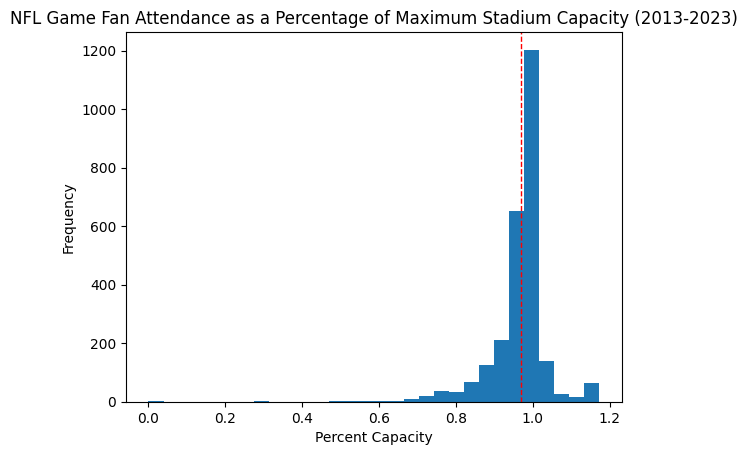

In [47]:
#Histogram

plt.hist(df["Percent Capacity"], bins = 30)
plt.axvline(df["Percent Capacity"].mean(), color='red', linestyle='dashed', linewidth=1)


plt.title("NFL Game Fan Attendance as a Percentage of Maximum Stadium Capacity (2013-2023)")
plt.xlabel("Percent Capacity")
plt.ylabel("Frequency")
plt.show()

#### From the Percent Capacity histogram, the data appears fairly normal with a mean just under 1.0. One notable piece is the sizeable spike around 1.15.

In [4]:
len(df.loc[(df["Percent Capacity"] > 1.05)])

109

#### Within the data, there were 109 instances of Stadium Percent Capacity exceeding 1.05. Many of these instances are attributed to Standing Room Only, which is not included in a stadium's official capacity measurement.

In [33]:
df.loc[(df["Percent Capacity"] > 1.05)].groupby(["Tm", "Year"]).agg(count = ("Percent Capacity", "count"))

count
Tm  Year       
CLE 2013      7
DAL 2013      7
    2014      8
    2015      8
    2016      8
    2017      8
    2018      8
    2019      8
    2021      8
    2022      9
    2023      8
LAR 2016      6
    2021      1
    2022      3
    2023      2
MIA 2013      3
    2014      7

In [8]:
len(df.loc[(df["Percent Capacity"] > 1.05) & (df["Tm"] == "DAL")])

80

#### Many of these instances (80 out of 109) were from Dallas Cowboys home games. This comes as no surprise because the Cowboys are the most popular team in America. Additionally, many of their fans are willing to attend home games with Standing Room only tickets.

In [24]:
df["Percent Capacity"].std()
df["Percent Capacity"].mean()
print(f"Mean Percent Capacity: {round(df["Percent Capacity"].mean(), 4)}\n"
      f"Std Dev Percent Capacity: {round(df["Percent Capacity"].std(), 4)}\n"
      f"Two Std Dev Below Mean: {round(df["Percent Capacity"].mean() - 2*df["Percent Capacity"].std(), 4)}")

Mean Percent Capacity: 0.9685
Std Dev Percent Capacity: 0.0728
Two Std Dev Below Mean: 0.8229


In [35]:
poor_attendance = df.loc[(df["Percent Capacity"] < 0.8229)].groupby(["Tm", "Year"]).agg(count = ("Percent Capacity", "count"))
poor_attendance[poor_attendance["count"] > 1].sort_values(by = "count", ascending = False)
# Removing One time instances below 82.29% Attendance

,,count
Tm,Year,
WAS,2018,8
TB,2018,7
CIN,2019,7
WAS,2021,7
LAR,2015,7
TB,2019,7
CIN,2018,6
WAS,2019,6
DET,2021,5


#### From this table, we can see that the Washington Commanders consistently have a high occurance of low fan attendance. Perhaps they need to offer some cheaper concession prices to lure fans out to games.

Text(0, 0.5, 'Attendance')

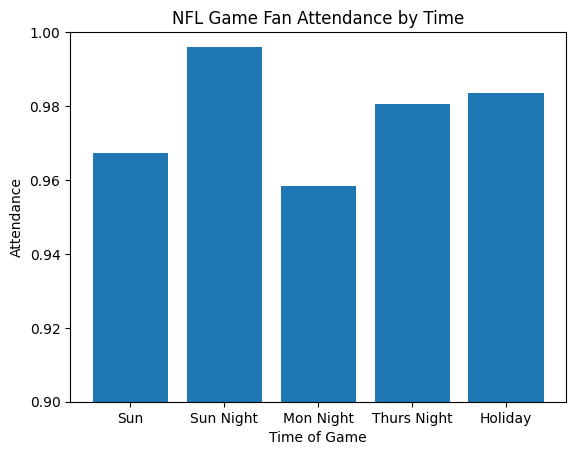

In [56]:
#Group By Time

gb_time = df.groupby("Time").agg(mean = ("Percent Capacity", "mean"))
times = ["Sun", "Sun Night", "Mon Night", "Thurs Night", "Holiday"]

plt.bar(times, gb_time["mean"])
plt.ylim(0.9, 1.0)
plt.title("NFL Game Fan Attendance by Time")
plt.xlabel("Time of Game")
plt.ylabel("Attendance")

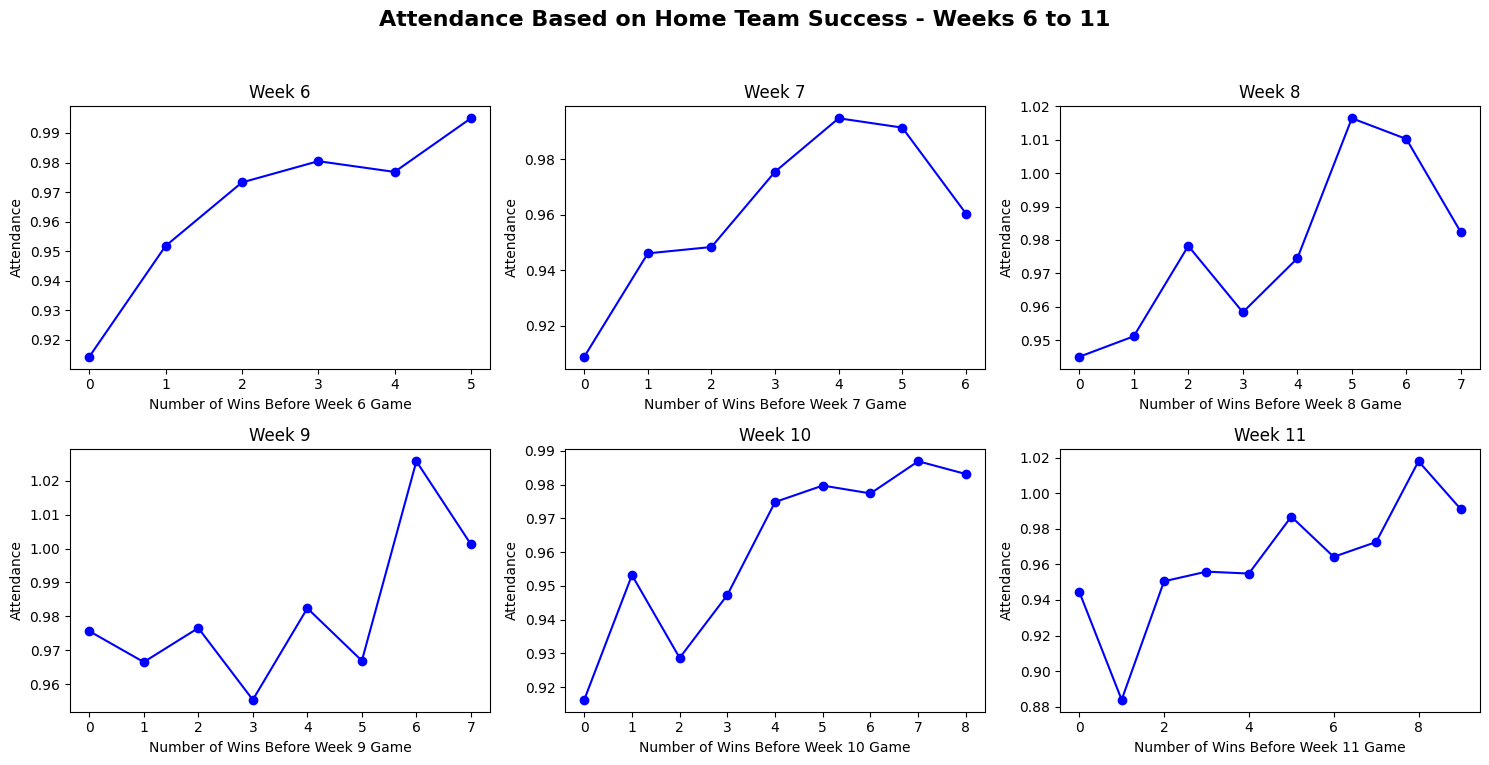

In [83]:
weeks = [6, 7, 8, 9, 10, 11]

fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 columns

for i, week in enumerate(weeks):
    # Select the current subplot
    ax = axs[i // 3, i % 3]  # Determine subplot position

    # Filter data for the current week
    wins_df = df[(df["Week"] == week) & (df["Home Team Wins"] != -1)].groupby("Home Team Wins").agg(mean_attendance=("Percent Capacity", "mean"))

    # Plot the data
    ax.plot(wins_df.index, wins_df["mean_attendance"], marker='o', linestyle='-', color='b')

    # Set title and labels
    ax.set_title(f"Week {week}")
    ax.set_xlabel(f"Number of Wins Before Week {week} Game")
    ax.set_ylabel("Attendance")

plt.suptitle("Attendance Based on Home Team Success - Weeks 6 to 11", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Machine Learning

In [111]:
# Setting up Independent and Dependent Variables
predictors = ["Week", "Away Team Wins", "Home Team Wins", "Time", "International"]
outcome = "Percent Capacity"

df["Time"] = df["Time"].astype(str)

x = pd.get_dummies(df[predictors], drop_first = True)
y = df[outcome]

for i in range(1,5):
    x[f"Time_{i}"] = x[f"Time_{i}"].astype(int)


x.head()

,Week,Away Team Wins,Home Team Wins,International,Time_1,Time_2,Time_3,Time_4
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0


## Multiple Linear Regression

### Data Partitioning

In [112]:
# Randomly splitting data into training set and testing set with 70/30 splits
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3, random_state = 1)


### Fitting the Model

In [116]:
lm = LinearRegression()

lm.fit(train_x, train_y)

LinearRegression()

# Printing coefficients
print(f"Y Intercept: {round(lm.intercept_, 4)} \n")
print(pd.DataFrame({'Predictor': x.columns, 'Coefficient': lm.coef_}))

#### From Initial Analysis of the First Linear Regression Fit, there are 2 negative coefficients. Week and Monday Night Football Variables negatively affect fan attendance. As the season progresses, attendance decreases. Wholistically, this makes sense because there are many teams with hopeful fans at the start of the season who are let down due to poor performance throughout the season. This discourages fans from attending home games later in the season.

In [127]:
# Print Performance Measures for Train Set
train_y_pred = lm.predict(train_x)

r2_train = sklearn.metrics.r2_score(train_y, train_y_pred)

RMSE_train = sklearn.metrics.root_mean_squared_error(train_y, train_y_pred)

print('R-squared on Train Set: %0.2f' %r2_train)
print('RMSE on Train Set: %0.2f' %RMSE_train)


R-squared on Train Set: 0.05
RMSE on Train Set: 0.07


#### Initial Performance of the Linear Regression Model was not able to explain much of the variance within the data

In [129]:
# Use predict() to make predictions on the test set
lm_pred = lm.predict(test_x)

# Glimpse of model's performance on test set
result = pd.DataFrame({'Predicted': lm_pred, 'Actual': test_y,
                       'Residual': test_y - lm_pred})
result.head()

,Predicted,Actual,Residual
2274,0.960564,1.000000,0.039436
1462,0.947207,0.967854,0.020647
2193,1.000701,0.961513,-0.039188
675,0.992515,1.011100,0.018585
607,0.957586,0.999333,0.041747


In [130]:
# Print Performance Measures for Test Set
r2_test = sklearn.metrics.r2_score(test_y, lm_pred)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, lm_pred)

print('R-squared on Test Set: %0.2f' %r2_test)
print('RMSE on Test Set: %0.2f' %RMSE_test)

R-squared on Test Set: 0.07
RMSE on Test Set: 0.07


#### Although Root Mean Squared Error improved slightly, the model is still not predicting Attendance accurately

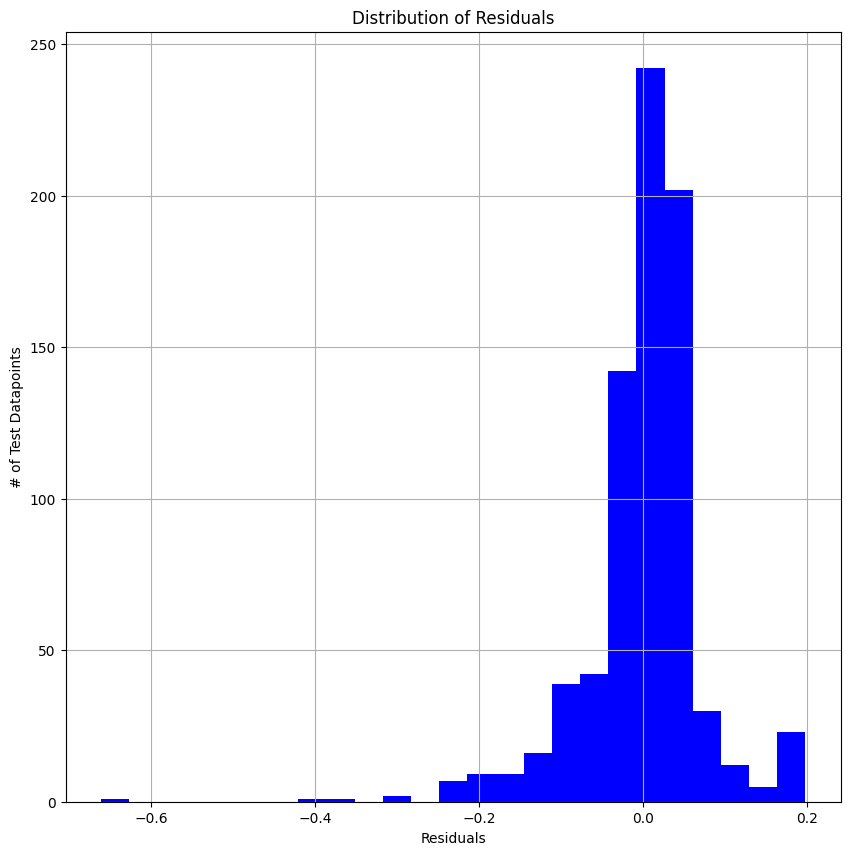

In [131]:
# Visualizing the distribution of Residuals
all_residuals = test_y - lm_pred

pd.DataFrame({'Residuals': all_residuals}).hist(bins=25, figsize=(10,10), color = 'blue')

plt.xlabel('Residuals')
plt.ylabel('# of Test Datapoints')
plt.title('Distribution of Residuals');

### Hyperparamer Tuning

In [134]:
# Creating folds for Cross Validation Grid
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

hyper_params = [{'n_features_to_select': list(range(1, 9))}]
hyper_params

[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8]}]

In [136]:
# Recursive Feature Elimination Algorithmm
rfe = RFE(lm)

In [137]:
# Implementing Cross Validation Grid Search for 5 different sets of (train/test) data
model_cv = GridSearchCV(estimator = rfe,
                        param_grid = hyper_params,
                        scoring= 'r2',
                        cv = folds,
                        return_train_score = True)

In [138]:
# Fitting the model with Cross Validation
model_cv.fit(train_x, train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8]}],
             return_train_score=True, scoring='r2')

In [139]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.021089,0.011973,0.007671,0.004250,1,{'n_features_to_select': 1},0.003018,-0.014528,0.002062,-0.003947,...,-0.000791,0.008075,6,0.006088,0.002134,0.005657,0.005668,0.004467,0.004803,0.001440
1,0.020520,0.006401,0.000709,0.001417,2,{'n_features_to_select': 2},-0.000098,-0.015154,0.000140,-0.004211,...,-0.002933,0.006724,7,0.007551,0.008927,0.006386,0.005911,0.005294,0.006814,0.001290
2,0.017567,0.004026,0.002145,0.002959,3,{'n_features_to_select': 3},-0.006393,-0.022336,0.000382,-0.003384,...,-0.005548,0.009092,8,0.008179,0.010044,0.006539,0.006346,0.005596,0.007341,0.001593
3,0.016501,0.011318,0.003139,0.006278,4,{'n_features_to_select': 4},-0.006019,-0.022232,-0.001193,0.031019,...,0.001129,0.017345,5,0.008215,0.010233,0.006590,0.019413,0.006159,0.010122,0.004861
4,0.008658,0.007192,0.007192,0.008813,5,{'n_features_to_select': 5},-0.020162,-0.020567,0.030585,0.031056,...,0.003393,0.023184,4,0.035076,0.010487,0.016363,0.019418,0.027035,0.021676,0.008565
5,0.013977,0.004313,0.003495,0.001469,6,{'n_features_to_select': 6},0.005228,0.002191,0.039014,0.081895,...,0.024881,0.032190,3,0.059675,0.025748,0.047717,0.039087,0.027037,0.039853,0.012795
6,0.010359,0.005778,0.002498,0.003099,7,{'n_features_to_select': 7},0.005175,0.029104,0.039738,0.082484,...,0.033882,0.027141,1,0.059676,0.050660,0.047796,0.039103,0.053457,0.050138,0.006775
7,0.007811,0.007921,0.004514,0.004686,8,{'n_features_to_select': 8},-0.010745,0.030261,0.037069,0.082526,...,0.029828,0.031202,2,0.063999,0.050680,0.047900,0.039781,0.054562,0.051384,0.007956


In [140]:
# Return set of parameters with the best performance
print(model_cv.best_params_)
# Return the performance metric score
print(model_cv.best_score_)


{'n_features_to_select': 7}
0.03388205190210136


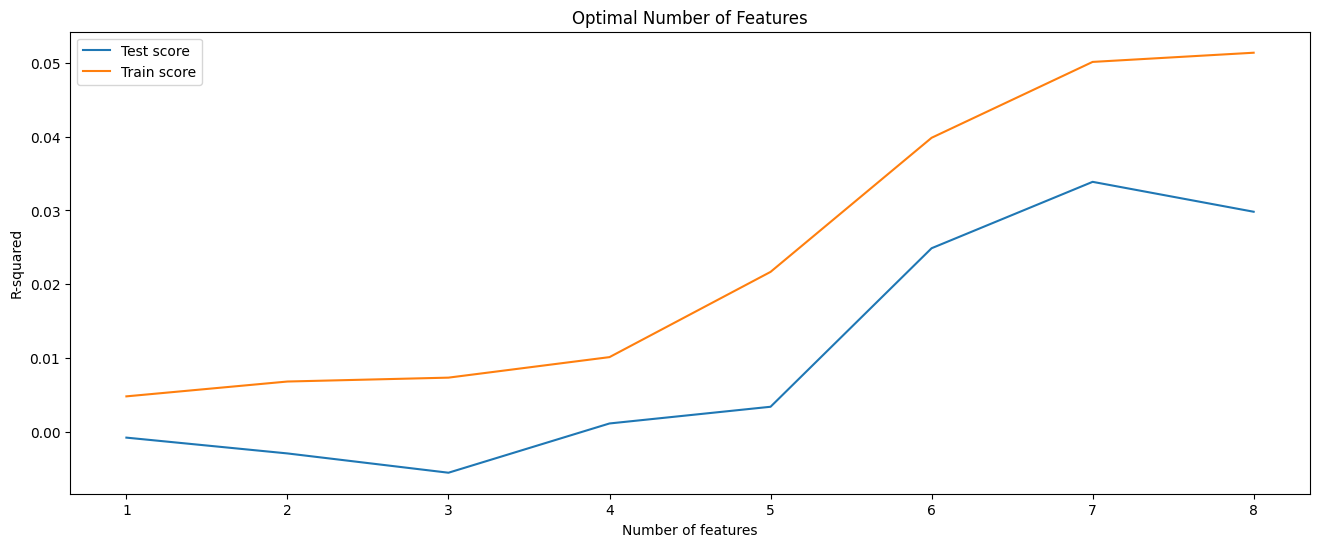

In [141]:
# Plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('Number of features')
plt.ylabel('R-squared')
plt.title("Optimal Number of Features")
plt.legend(['Test score', 'Train score'], loc='upper left');

In [143]:
# Tuples of (feature name, whether selected, ranking)
df = pd.DataFrame(list(zip(train_x.columns, model_cv.best_estimator_.support_, model_cv.best_estimator_.ranking_)),
                  columns = ['Feature','Whether selected', 'Rank'])

df

,Feature,Whether selected,Rank
0,Week,True,1
1,Away Team Wins,False,2
2,Home Team Wins,True,1
3,International,True,1
4,Time_1,True,1
5,Time_2,True,1
6,Time_3,True,1
7,Time_4,True,1


#### From this table, Away Team Wins is not a great predictor of NFL game attendance. The Linear Regression Model performed better without using it.

In [147]:
# Displaying features and their coefficients that were selected by RFE
df_true = df.loc[df['Whether selected'] == True]
df_true = df_true.drop(columns = ['Whether selected', 'Rank'])
df_true["Coefficients"] = model_cv.best_estimator_.estimator_.coef_
df_true = df_true.reset_index(drop = True)

print(f"Y Intercept: {round(model_cv.best_estimator_.estimator_.intercept_, 4)} \n")
print(df_true)

Y Intercept: 0.9721 

          Feature  Coefficients
0            Week     -0.003212
1  Home Team Wins      0.006839
2   International      0.009862
3          Time_1      0.022740
4          Time_2     -0.006417
5          Time_3      0.007333
6          Time_4      0.005732


In [148]:
# Print Performance Measures for Test Set (Without Away Team Wins Value)
y_pred = model_cv.best_estimator_.predict(test_x)

r2_test = sklearn.metrics.r2_score(test_y, lm_pred)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, lm_pred)

print('R-squared on Test Set: %0.2f' %r2_test)
print('RMSE on Test Set: %0.2f' %RMSE_test)


R-squared on Test Set: 0.07
RMSE on Test Set: 0.07


## Decision Tree Model

In [156]:
tree = DecisionTreeRegressor(random_state = 99)

# Starting with an initial guess for parameters
hyper_params = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [20, 40, 60],
    'min_samples_leaf': [10, 20, 30, 40, 50]
}

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

In [157]:
model_cv = GridSearchCV(estimator = tree,
                        param_grid = hyper_params,
                        scoring = 'r2',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1)

### Fitting the Model

In [158]:
# Fit the model
model_cv.fit(train_x, train_y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=99), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [10, 20, 30, 40, 50],
                         'min_samples_split': [20, 40, 60]},
             scoring='r2', verbose=1)

In [162]:
print(f"Initial score: {round(model_cv.best_score_, 4)}")
print(f"Initial parameters:{model_cv.best_params_}")

Initial score: 0.0131
Initial parameters:{'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 20}


### Hyperparameter Tuning

In [180]:
# Adapt grid based on result from initial grid search
hyper_params_new = {
    'max_depth': list(range(2, 14)),
    'min_samples_split': list(range(47, 53)),
    'min_samples_leaf': list(range(18, 23))
}

In [181]:
model_cv = GridSearchCV(estimator = tree,
                        param_grid = hyper_params_new,
                        scoring = 'r2',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1)

### Re-fitting the Model With Hyperparameter Adjustments

In [182]:
# Re-fit the model
model_cv.fit(train_x, train_y)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=99), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
                         'min_samples_leaf': [18, 19, 20, 21, 22],
                         'min_samples_split': [47, 48, 49, 50, 51, 52]},
             scoring='r2', verbose=1)

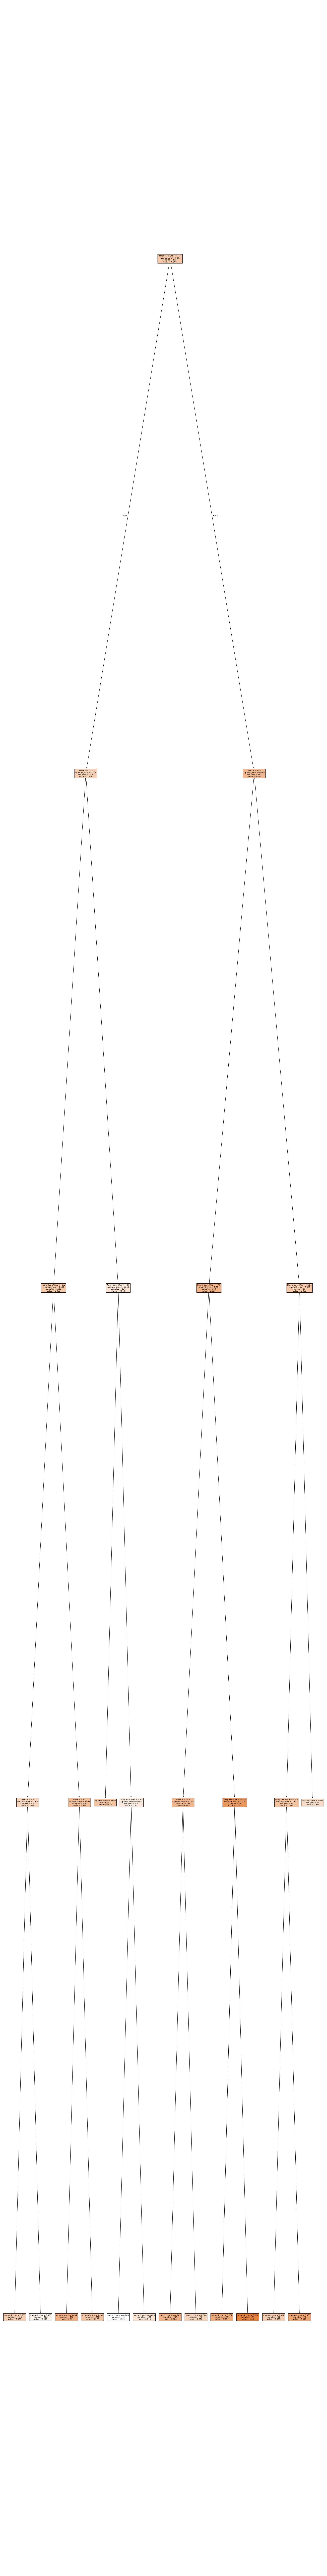

In [186]:
# Storing best model
bestRegTree = model_cv.best_estimator_

# Visualizing Decision Tree
fig = plt.figure(figsize = (25, 200))
a = tree.plot_tree(decision_tree = bestRegTree,
                   feature_names = train_x.columns,
                   filled = True)

In [178]:
y_pred = model_cv.predict(test_x)
r2 = sklearn.metrics.r2_score(test_y, y_pred)
RMSE = sklearn.metrics.root_mean_squared_error(test_y, y_pred)
print(f"R Squared: {round(r2, 4)}")
print(f"Root Mean Squared Error: {round(RMSE, 4)}")

R Squared: 0.0178
Root Mean Squared Error: 0.076


In [187]:
# Storing importance values from the best fit model
importance = model_cv.best_estimator_.feature_importances_

In [189]:
# Displaying feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_x.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

feature_imp

,Feature,Importance
0,Week,0.460313
1,Home Team Wins,0.407421
2,Away Team Wins,0.132265
3,International,0.000000
4,Time_1,0.000000
5,Time_2,0.000000
6,Time_3,0.000000
7,Time_4,0.000000


<function matplotlib.pyplot.show(close=None, block=None)>

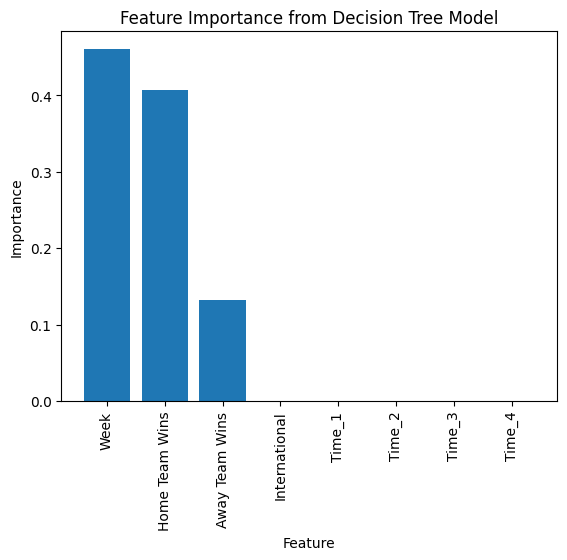

In [194]:
plt.bar(feature_imp["Feature"], feature_imp["Importance"])

plt.xticks(rotation = 90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance from Decision Tree Model")
plt.show

#### In the Decision Tree Model, 3 variables accounted for nearly all of the feature importance in predicting fan attendance at NFL Games. Week of the game was the most important variable in predicting attendance, followed by Number of Wins the Home Team had before the game.

## Random Forest Model

In [200]:
forest = RandomForestRegressor(random_state = 42)

# Start with an initial guess for parameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 20, num = 10)]

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 20]

# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 20]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 'min_samples_split': [5, 10, 20], 'min_samples_leaf': [5, 10, 20]}


In [206]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

model_cv = RandomizedSearchCV(estimator = forest,
                              param_distributions = random_grid,
                              n_iter = 100,
                              scoring = 'r2',
                              cv = folds,
                              verbose = 2,
                              random_state = 42,
                              n_jobs = -1)

### Fitting the Model

In [207]:
# Fit the model
start = time.time()            # Start Time
model_cv.fit(train_x, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Training time: 167.36817693710327s


In [208]:
print(f"Initial score: {round(model_cv.best_score_, 4)}")
print(f"Initial parameters:{model_cv.best_params_}")

Initial score: 0.0275
Initial parameters:{'n_estimators': 250, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_depth': 4}


### Hyperparameter Tuning

In [209]:
# Create the parameter grid based on the results of random search
param_grid = {
    'max_depth': [3, 3, 5],
    'min_samples_leaf': [15, 20, 25, 30],
    'min_samples_split': [15, 20, 25, 30],
    'n_estimators': [180, 200, 220]
}

print(param_grid)

{'max_depth': [3, 3, 5], 'min_samples_leaf': [15, 20, 25, 30], 'min_samples_split': [15, 20, 25, 30], 'n_estimators': [180, 200, 220]}


### Re-fitting the Model

In [210]:
# Call GridSearchCV()
model_cv = GridSearchCV(estimator = forest,
                        param_grid = param_grid,
                        scoring= 'r2',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1)

In [212]:
# Re-fit the model
start = time.time()            # Start Time
model_cv.fit(train_x, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 144 candidates, totalling 720 fits


C:\Users\petew\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Training time: 155.3303713798523s


In [213]:
print(f"Improved score: {round(model_cv.best_score_, 4)}")
print(f"Improved parameters:{model_cv.best_params_}")

Improved score: 0.0295
Improved parameters:{'max_depth': 5, 'min_samples_leaf': 30, 'min_samples_split': 15, 'n_estimators': 180}


In [215]:
# Saving model to local drive
filename = 'RandomForest_model.sav'
pickle.dump(model_cv, open(filename, 'wb'))

### Feature Importance

In [217]:
# Storing importance values from the best fit model
importance = model_cv.best_estimator_.feature_importances_

In [219]:
# Displaying feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_x.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

feature_imp

,Feature,Importance
0,Home Team Wins,0.446082
1,Week,0.427519
2,Away Team Wins,0.111524
3,Time_1,0.011442
4,Time_2,0.003433
5,International,0.000000
6,Time_3,0.000000
7,Time_4,0.000000


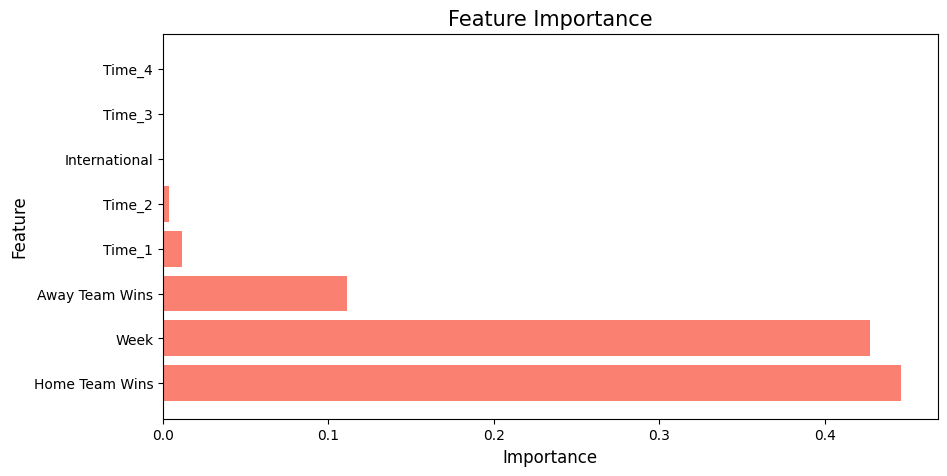

In [220]:
# Bar plot
plt.figure(figsize=(10, 5), dpi = 100)
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color ='salmon')

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Feature", fontsize = 12)
plt.title("Feature Importance", fontsize = 15);

### Similar to the Decision Tree Model, the Random Forest Model relies mainly on same 3 variables. However, the Random Forest Model made use of the Sunday Night Football and Monday Night Football variables